In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

output_directory = '/home/marco/DataspellProjects/thesis/output/pls/ST002498/'

palette = sns.color_palette(["#2176AB", "#F97662", "#FFBF00", "#50C878", "#B284BE"])
sns.set(style="whitegrid", font_scale=1.5)
sns.set_palette(palette)

df = pd.read_csv('../../../data/ST002498_z.csv')
df.describe()

,Age,Height,Weight,S-1-pyrroline-5-carboxylate,spermidine,1-methylnicotinamide,3-phosphoglycerate,"5,6-dihydrothymine",hypoxanthine,quinolinate,...,X-25519,X-25520,X-25790,X-25810,X-25828,X-25855,X-25948,X-25957,X-26097,Diagnosis
count,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,...,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.0000
mean,0.007425,0.010053,0.000285,0.011043,-0.008243,-0.007791,-0.010447,0.017833,-0.018459,-0.003517,...,-0.006615,-0.004873,-0.007584,0.000437,0.015021,-0.006455,-0.008275,-0.013349,-0.003308,0.5000
std,0.992131,0.967925,0.986467,1.008773,0.964372,0.964043,0.970150,0.981421,0.980179,0.969777,...,0.976524,0.971150,0.964506,0.969813,0.984631,0.964650,0.964612,0.974690,0.971573,0.5004
min,-3.677439,-10.675699,-5.417313,-1.998392,-0.540645,-0.219073,-1.291631,-4.367928,-1.453987,-0.868538,...,-1.220973,-0.857353,-0.425937,-0.358053,-3.294444,-0.721937,-0.536808,-1.754904,-2.530248,0.0000
25%,-0.657136,-0.205737,-0.578473,-0.708038,-0.215238,-0.163752,-0.462960,-0.615635,-0.686302,-0.361391,...,-0.470149,-0.456672,-0.203076,-0.279605,-0.642269,-0.220701,-0.207818,-0.359027,-0.459041,0.0000
50%,0.039857,0.016030,-0.106391,-0.151390,-0.109196,-0.139170,-0.226522,-0.037622,-0.268016,-0.198360,...,-0.224252,-0.268090,-0.114908,-0.215108,0.100297,-0.104594,-0.133198,-0.022854,-0.143522,0.5000
75%,0.620684,0.325935,0.483711,0.558186,0.004333,-0.097251,0.110589,0.570203,0.446424,0.090995,...,0.127872,0.120560,-0.001271,-0.030181,0.698217,0.011532,-0.019935,0.309724,0.286015,1.0000
max,2.363167,1.565556,3.876800,4.389207,20.596352,13.796128,8.476954,3.702734,5.256337,15.695124,...,10.537399,13.784214,18.979855,19.947659,4.833957,16.115889,16.932171,11.767541,10.014955,1.0000


Performing PLSDA on the dataset using the roc_auc scoring metric and 10-fold cross validation.

In [2]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

components = np.arange(1,15)
scores = []
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for i in components:
    kscores = []
    #10-fold cross validation
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pls = PLSRegression(n_components=i)
        pls.fit(X_train, y_train)

        X_train_pls = pls.transform(X_train)
        X_test_pls = pls.transform(X_test)

        logreg = LogisticRegression(max_iter=1000)
        logreg.fit(X_train_pls, y_train)

        y_pred = logreg.predict(X_test_pls)
        kscores.append(accuracy_score(y_test, y_pred))

    scores.append(kscores)

#getting scores distribution for each number of components
scores = np.array(scores)
score_mean = np.mean(scores, axis=1)
score_std = np.std(scores, axis=1)
score_25 = np.quantile(scores, 0.25, axis=1)
score_75 = np.quantile(scores, 0.75, axis=1)


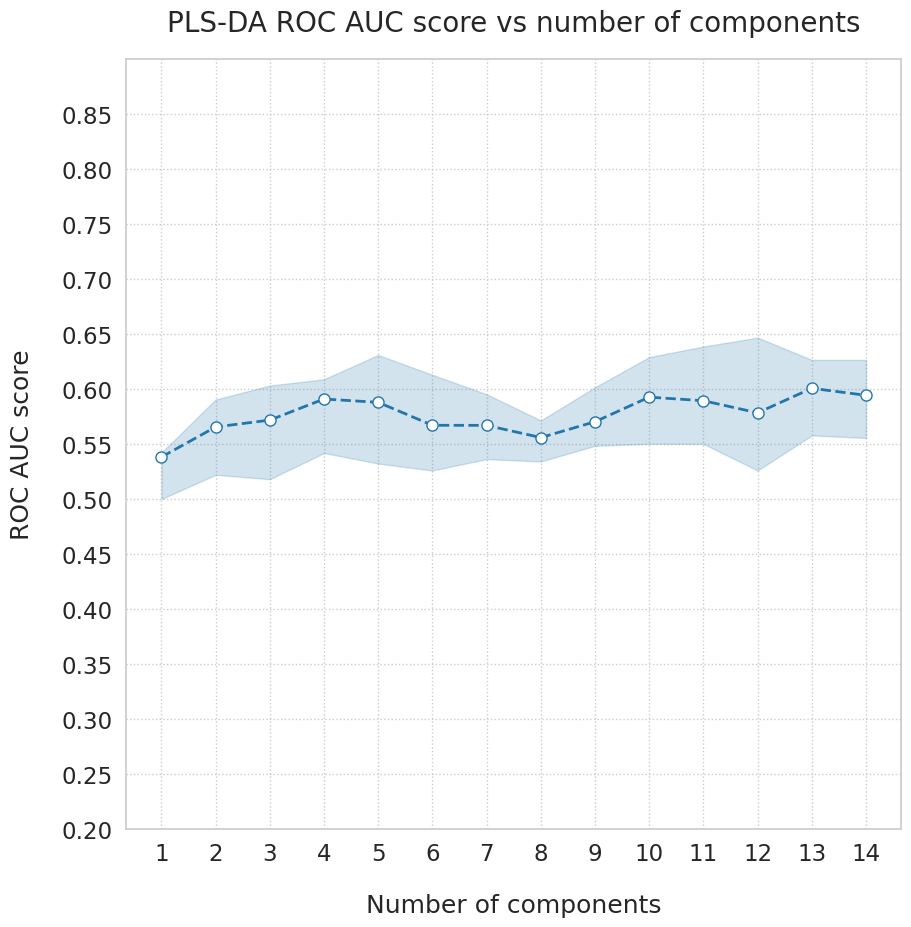

In [4]:
plt.figure(figsize=(10, 10))

# boxplot showing the distribution of the scores using line and markers
plt.plot(components, score_mean, color=palette[0], marker='o', markersize=8, linestyle='--', markeredgecolor=palette[0], markerfacecolor='white', linewidth=2)
plt.fill_between(components, score_25, score_75, color=palette[0], alpha=0.2)

# y axis limits
plt.ylim(0.2, 0.9)

# show plot grid
plt.xticks(components)
plt.yticks(np.arange(0.2, 0.9, 0.05))
plt.grid(True, linestyle=':', linewidth=1)
plt.xlabel('Number of components', labelpad=20)
plt.ylabel('ROC AUC score', labelpad=20)
plt.title('PLS-DA ROC AUC score vs number of components', fontsize=20, pad=20)
plt.savefig(output_directory + 'PLS-DA_number_of_components.png', dpi=300)


In [5]:
from sklearn.metrics import roc_curve, auc, accuracy_score

roc_pls = PLSRegression(n_components=4)

roc_scores = {'accuracy': [], 'roc_auc': [], 'fpr': [], 'tpr': []}


for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    roc_pls.fit(X_train, y_train)

    X_train_pls = roc_pls.transform(X_train)
    X_test_pls = roc_pls.transform(X_test)

    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train_pls, y_train)

    y_pred = logreg.predict(X_test_pls)
    y_prob = logreg.predict_proba(X_test_pls)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob, drop_intermediate=False)

    roc_scores['accuracy'].append(accuracy_score(y_test, y_pred))
    roc_scores['roc_auc'].append(roc_auc_score(y_test, y_prob))
    roc_scores['fpr'].append(fpr.tolist())
    roc_scores['tpr'].append(tpr.tolist())

In [6]:
scores_df = pd.read_csv('../../../output/scores.csv')

scores_df = scores_df.append({
    'Model': 'PLS-DA',
    'Dataset': 'ST002498',
    'auc': roc_scores['roc_auc'],
    'accuracy': roc_scores['accuracy'],
    'fpr': roc_scores['fpr'],
    'tpr': roc_scores['tpr']
}, ignore_index=True)
scores_df.to_csv('../../../output/scores.csv', index=False)

/tmp/ipykernel_27504/1021021841.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({


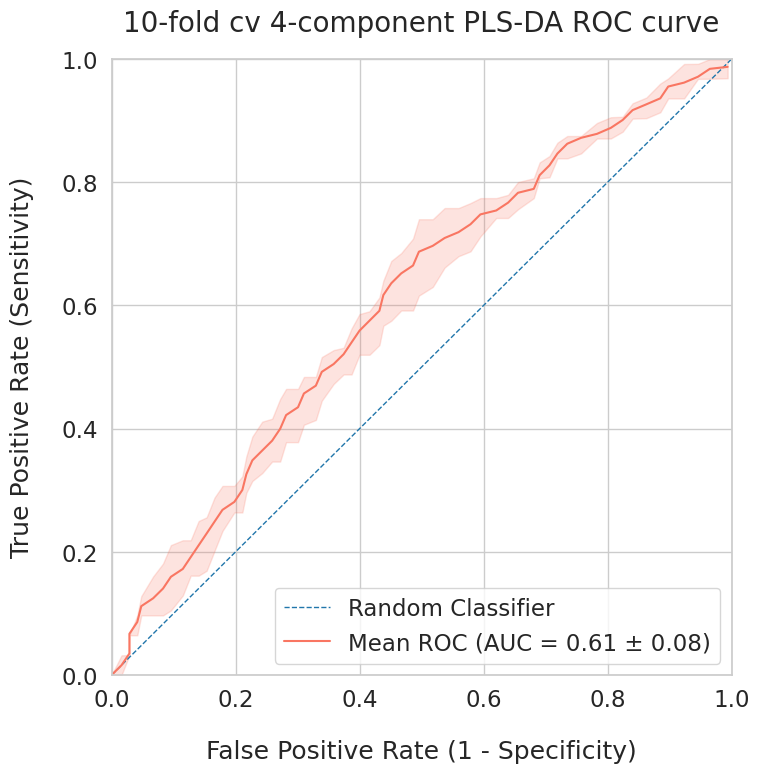

In [7]:

plt.figure(figsize=(8, 8))
# plotting the random line
plt.plot([0, 1], [0, 1], lw=1, linestyle='--', label='Random Classifier')

# Assicurati che tutte le liste di FPR e TPR abbiano la stessa lunghezza
max_length_fpr = min([len(lst) for lst in roc_scores['fpr']])
max_length_tpr = min([len(lst) for lst in roc_scores['tpr']])
roc_scores['fpr'] = [lst[:max_length_fpr] for lst in roc_scores['fpr']]
roc_scores['tpr'] = [lst[:max_length_tpr] for lst in roc_scores['tpr']]

# Calcola la media dei valori di FPR e TPR e l'AUC
mean_fpr = np.mean(roc_scores['fpr'], axis=0)
mean_tpr = np.mean(roc_scores['tpr'], axis=0)
mean_auc = np.mean(roc_scores['roc_auc'])

# Calcola 25 e 75 percentile
percentile_25_tpr = np.quantile(roc_scores['tpr'], 0.25, axis=0)
percentile_75_tpr = np.quantile(roc_scores['tpr'], 0.75, axis=0)

# Traccia la curva ROC media
plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.2f} ± {np.std(roc_scores["roc_auc"]):.2f})')

# Traccia la regione di deviazione standard
plt.fill_between(mean_fpr, percentile_25_tpr, percentile_75_tpr, color=palette[1], alpha=0.2)

# Personalizza il grafico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', labelpad=20)
plt.ylabel('True Positive Rate (Sensitivity)', labelpad=20)
plt.title('10-fold cv 4-component PLS-DA ROC curve', fontsize=20, pad=20)
plt.legend(loc='lower right')
plt.savefig(output_directory + 'PLS-DA_roc_curve.png', dpi=300, bbox_inches='tight') 
